# 手写数字全连接模型 

## 关于批次的模糊点补充  
在深度学习领域，"批次"（batch）和"批"实际上是同一个概念的不同翻译或表述方式。通常，在提到神经网络训练时，我们会使用"批次"这个术语来描述一次提供给模型进行前向传播和反向传播的数据量。

### 批次（Batch）

1. **定义**：批次是指在训练过程中用于一次更新权重的样本集合。简单来说，就是每次迭代中使用的数据子集。
   
2. **作用**：
   - **加速计算**：通过并行处理一批数据而不是逐个处理单个数据点，可以更高效地利用GPU等硬件资源，从而加快训练速度。
   - **改善收敛性**：批量梯度下降可以在减少参数更新的方差的同时，保持较低的计算成本，有助于更平稳地收敛到全局最小值。
   
3. **类型**：
   - **全批量（Full Batch）**：使用整个训练集来进行一次参数更新。对于大型数据集来说，这可能不太实际，因为需要大量的内存和计算能力。
   - **小批量（Mini-batch）**：这是最常用的方式，指的是将数据集分成多个小批次，每个批次包含一定数量的样本。这种方法能够在计算效率和收敛速度之间取得平衡。
   - **在线学习（Online Learning）/ 单例批次（Batch size of 1）**：每使用一个样本就更新一次模型参数。这种方式适用于流数据或者当数据量非常大而无法全部加载到内存中的情况。

4. **选择合适的批次大小**：
   - 批次大小的选择对模型性能有显著影响。较小的批次大小可以引入噪声，帮助跳出局部最优解；较大的批次大小则能提高计算效率，并且在某些情况下能够达到更好的泛化效果。但是，批次太大可能导致内存不足的问题。

总之，在深度学习中讨论“批次”或“批”的时候，都是指在训练神经网络时一次性输入模型进行训练的一组数据。正确选择批次大小是优化模型训练过程的一个重要方面。

## squee的作用就是删除维度为1的维度

In [1]:
import torch 
from torch import nn 
import torch.nn.functional as F 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from torch.utils.data import TensorDataset,DataLoader 
from sklearn.model_selection import train_test_split

## 模板代码 

### 创建fit()函数

In [2]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
   
    #创建俩列表接收损失值和精度值
    train_loss_lst = []
    train_acc_lst = []
    tst_loss_lst=[]
    tst_acc_lst=[]
  
    Model_m.train()  # 设置为训练模式
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
   
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了灯饰可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval()
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


### 创建模型

```python
class Model(nn.Module):
    def __init__(self): 
        super().__init__() 
        self.liner_1 = nn.Linear() 
        self.liner_2 = nn.Linear()  
        self.liner_3 = nn.Linear() 
    #定义前向传播  
    def forward(self,input): 
        pass 

model = Model()
```

### 创建损失函数和优化函数

```python
loss_fn = nn.CrossEntropyLoss()
optim = nn.optim.xxx(model.parameters(),lr=0.001) #传入要优化的模型的参数并指定学习率
```

### 定义batch和接收返回值以及训练

```python
batch = 8 #定义batchsize
DS_train = TensorDataset(train_x,train_y)
DL_train = DataLoader(DS_train,batch_size=batch,shuffle=True)

DS_test = TensorDataset(test_x,test_y)
DL_test = DataLoader(DS_test,batch_size=batch)  

epochs = 50 

train_loss_gpu=[] 
train_acc_gpu =[] 
tst_loss_gpu = [] 
tst_acc_gpu=[] 
for epoch in range(epochs): 
    epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc = fit_gpu(Train_DL=DL_train,TST_DL=DL_test,Model_m=model_gpu,epoch_=epoch,optim=optim_gpu,loss_fn=loss_fn_gpu)
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
```

## 卷积神经网络

### 手写数字分类

##### torchvision内置了常用的数据集和模型

为了方便为我们转换数据集,它还内置了一个transform方法

In [3]:
import torchvision
from torchvision import datasets, transforms


In [4]:
datasets??

Type:        module
String form: <module 'torchvision.datasets' from 'D:\\venvs\\dl\\Lib\\site-packages\\torchvision\\datasets\\__init__.py'>
File:        d:\venvs\dl\lib\site-packages\torchvision\datasets\__init__.py
Source:     
from ._optical_flow import FlyingChairs, FlyingThings3D, HD1K, KittiFlow, Sintel
from ._stereo_matching import (
    CarlaStereo,
    CREStereo,
    ETH3DStereo,
    FallingThingsStereo,
    InStereo2k,
    Kitti2012Stereo,
    Kitti2015Stereo,
    Middlebury2014Stereo,
    SceneFlowStereo,
    SintelStereo,
)
from .caltech import Caltech101, Caltech256
from .celeba import CelebA
from .cifar import CIFAR10, CIFAR100
from .cityscapes import Cityscapes
from .clevr import CLEVRClassification
from .coco import CocoCaptions, CocoDetection
from .country211 import Country211
from .dtd import DTD
from .eurosat import EuroSAT
from .fakedata import FakeData
from .fer2013 import FER2013
from .fgvc_aircraft import FGVCAircraft
from .flickr import Flickr30k, Flickr8k
from

### 加载数据集

### transforms.ToTensor的两个作用就是 
1. 将读取的数据转换为张量
2. 将数据归一化(如图片数据),转为(0-1)之间的数

#### 准备训练集

In [5]:
transformation = transforms.Compose(
    [
        transforms.ToTensor(), #将读取的数据转换为张量
        # transforms.Normalize() #初学不建议
        #标准化到-1~1之间
        
    ]
)

In [6]:

DS_Train = datasets.MNIST(
    './dataset/', #指定数据的下载位置 
    train=True, #声明是Train数据 
    transform=transformation, #要做的变换
    download=False, #是否下载,这里我已经下载了,就不浪费流量了
)

In [7]:
type(DS_Train)

torchvision.datasets.mnist.MNIST

#### 准备测试集

In [8]:
DS_Test = datasets.MNIST(
    './dataset/', #指定数据的下载位置 
    train=False, #非Train数据集 
    transform=transformation, #要做的变换
    download=False, #是否下载
)

注意,直接返回的就是tensordataset那样的数据集,所以可以直接下一步处理成dataloader

In [9]:
DL_train = DataLoader(DS_Train,batch_size=64,shuffle=True)
DL_test = DataLoader(DS_Test,batch_size=256,shuffle=False)
#测试集并不需要反向传播,所以占用资源比较小,所以可以提升测试集
# 的batchsize

In [10]:
type(DL_train)

torch.utils.data.dataloader.DataLoader

#### 看看数据集长什么样

拿出一个批次,看看这玩意儿长什么样子

#### 注意这玩意儿有俩返回值,一个是图片,一个是图片对应的标签

In [27]:
img64,labels = next(iter(DL_train))

In [29]:
img64.shape

torch.Size([64, 1, 28, 28])

batchsize是64,一个通道(chanel),$28\times28$ 的图像（n,c,h,w）

在pytorch里面图片的表示形式就是  
$(n(batch),c(chanel),h(height),w(width))$

取出第一张图片

In [30]:
imgs = img64[0] 

In [31]:
imgs.shape

torch.Size([1, 28, 28])

转换为ndarry,但是第一个维度我们并不需要,  
所以利用squeeze将其去掉

In [32]:
img = imgs.numpy()
img = np.squeeze(img)

In [33]:
img.shape

(28, 28)

#### 绘制图片 

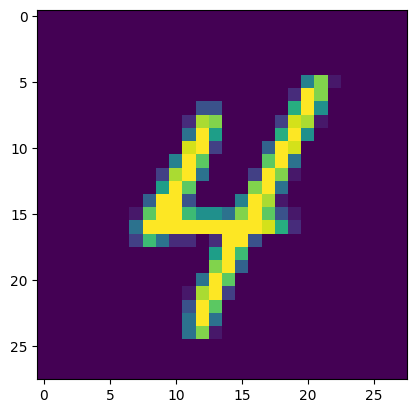

In [34]:
plt.imshow(img)

#### 查看对应的标签数据

In [35]:
labels[0]

tensor(4)

可以看到对应的是正确的

定义一个函数imshow用来绘制图片

In [36]:
def imshow(img):  
    npimg = img.numpy()
    img_ = np.squeeze(npimg)
    plt.imshow(img_)
    
    

取出十张图片

创建画布,大小为10*1

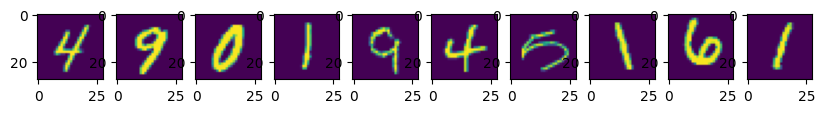

In [37]:
plt.figure(figsize=(10,1))
for i,img in enumerate(img64[:10]): 
    plt.subplot(1,10,i+1) #绘制的是1行10列的第i+1张图
    imshow(img)

In [38]:
labels[:10]

tensor([4, 9, 0, 1, 9, 4, 5, 1, 6, 1])

可以看到都是一一对应的

### 创建全连接模型

每张图片展开的像素个数

In [39]:
28*28

784

类别个数

In [40]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [44]:
 class Model(nn.Module): 
     def __init__(self):
         super().__init__()  
         self.liner_1 = nn.Linear(784,120)
         self.liner_2 = nn.Linear(120,84)
         self.liner_3 = nn.Linear(84,10) #0-9所以是10分类
     def forward(self,input): 
         #展平操作 ,将输入展平成28*28的张量
         x = input.view(-1,28*28)
         x = F.relu(self.liner_1(x))  
         x = F.relu(self.liner_2(x))
         x = F.relu(self.liner_3(x))
         return x

#### 创建模型

In [45]:
model = Model()

In [49]:
model

Model(
  (liner_1): Linear(in_features=784, out_features=120, bias=True)
  (liner_2): Linear(in_features=120, out_features=84, bias=True)
  (liner_3): Linear(in_features=84, out_features=10, bias=True)
)

#### 创建损失函数和优化函数

In [50]:
lr = 0.001
lossfn = nn.CrossEntropyLoss()
optm = torch.optim.Adam(model.parameters(),lr=lr)

In [51]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
    
   
    #创建俩列表接收损失值和精度值
    train_loss_lst = []
    train_acc_lst = []
    tst_loss_lst=[]
    tst_acc_lst=[]
  
    Model_m.train()  # 设置为训练模式
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
   
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了灯饰可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval()
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


In [52]:
model_gpu = Model()
optim_gpu = torch.optim.Adam(model_gpu.parameters(),lr=0.001)
loss_fn_gpu = nn.CrossEntropyLoss() 
# DL_train = DataLoader(DS_train,batch_size=batch,shuffle=True)
# DL_test = DataLoader(DS_test,batch_size=batch)  
DL_train = DataLoader(DS_Train,batch_size=64,shuffle=True)
DL_test = DataLoader(DS_Test,batch_size=256,shuffle=False)

epochs = 50 

train_loss_gpu=[] 
train_acc_gpu =[] 
tst_loss_gpu = [] 
tst_acc_gpu=[] 
for epoch in range(epochs): 
    epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc = fit_gpu(Train_DL=DL_train,TST_DL=DL_test,Model_m=model_gpu,epoch_=epoch,optim=optim_gpu,loss_fn=loss_fn_gpu)
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)

epoch:0 | loss:0.021 | acc:0.556 | tstloss:0.005 | tstacc:0.574
epoch:1 | loss:0.018 | acc:0.582 | tstloss:0.004 | tstacc:0.587
epoch:2 | loss:0.016 | acc:0.589 | tstloss:0.004 | tstacc:0.589
epoch:3 | loss:0.015 | acc:0.592 | tstloss:0.004 | tstacc:0.588
epoch:4 | loss:0.015 | acc:0.593 | tstloss:0.004 | tstacc:0.590
epoch:5 | loss:0.015 | acc:0.594 | tstloss:0.004 | tstacc:0.589
epoch:6 | loss:0.015 | acc:0.596 | tstloss:0.004 | tstacc:0.589
epoch:7 | loss:0.015 | acc:0.596 | tstloss:0.004 | tstacc:0.588
epoch:8 | loss:0.015 | acc:0.596 | tstloss:0.004 | tstacc:0.590
epoch:9 | loss:0.015 | acc:0.596 | tstloss:0.004 | tstacc:0.588
epoch:10 | loss:0.015 | acc:0.597 | tstloss:0.004 | tstacc:0.589
epoch:11 | loss:0.015 | acc:0.598 | tstloss:0.004 | tstacc:0.590
epoch:12 | loss:0.015 | acc:0.597 | tstloss:0.004 | tstacc:0.588
epoch:13 | loss:0.015 | acc:0.597 | tstloss:0.004 | tstacc:0.589
epoch:14 | loss:0.015 | acc:0.598 | tstloss:0.004 | tstacc:0.588
epoch:15 | loss:0.015 | acc:0.598 |

In [55]:
import pickle as pkl 
with open('./mymodel/forminist.pkl','wb') as f : 
    pkl.dump(model_gpu,f)